In [438]:
!pip install pyspark==4.0.0

In [439]:
import os

os.makedirs('data', exist_ok=True)

In [440]:
 #!/bin/bash
# Download datasets from Kaggle using their API

!curl -L -o ./data/gdp-countries.zip \
    "https://www.kaggle.com/api/v1/datasets/download/nitishabharathi/gdp-per-capita-all-countries"

!curl -L -o ./data/marine-microplastic.zip \
    "https://www.kaggle.com/api/v1/datasets/download/william2020/marine-microplastics"

!curl -L -o ./data/food-microplastic.zip \
    "https://www.kaggle.com/api/v1/datasets/download/jayeshrmohanani/dataset-for-microplastic-consumption-in-food-items"

!curl -L -o ./data/life-exp-countries.zip \
    "https://www.kaggle.com/api/v1/datasets/download/sahirmaharajj/country-health-trends-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 44393  100 44393    0     0  63892      0 --:--:-- --:--:-- --:--:--  586k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1681k  100 1681k    0     0  1235k      0  0:00:01  0:00:01 --:--:-- 3265k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  115k  100  115k    0     0   140k      0 --:--:-- --:--:-- --:--:--  140k
  % Total    % Received % Xferd  Average Speed   Tim

In [441]:
# Unzip the downloaded datasets

import zipfile
import os

def unzip_dataset(dataset_name):
    try:
        with zipfile.ZipFile(f'./data/{dataset_name}.zip', 'r') as zip_ref:
            zip_ref.extractall('./data/')
            print("Extracted marine microplastic dataset")
    except zipfile.BadZipFile:
        print(f"{dataset_name} file is not a valid zip")

unzip_dataset('marine-microplastic')
unzip_dataset('life-exp-countries')
unzip_dataset('gdp-countries')
unzip_dataset('food-microplastic')

# List all files in data directory
print("\nAll files in data directory:")
for file in os.listdir('./data/'):
    print(f"- {file}")

Extracted marine microplastic dataset
Extracted marine microplastic dataset
Extracted marine microplastic dataset
Extracted marine microplastic dataset

All files in data directory:
- train.csv
- gold
- GDP.parquet
- train.parquet
- gapminder.parquet
- marine-microplastic.zip
- processed_microplastics.parquet
- gdp-countries.zip
- plots
- food-microplastic.zip
- GDP.csv
- life-exp-countries.zip
- processed_microplastics.csv
- silver
- Marine_Microplastics.csv
- gapminder.csv
- Marine_Microplastics.parquet


In [442]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("MicroplasticsAnalysis") \
    .getOrCreate()

In [443]:
# Create Bronze layer with explicit schemas

from pyspark.sql.types import *
from pyspark.sql.functions import *

ocean_schema = StructType([
    StructField("OBJECTID", IntegerType(), True),
    StructField("Oceans", StringType(), True),
    StructField("Regions", StringType(), True),
    StructField("SubRegions", StringType(), True),
    StructField("Sampling Method", StringType(), True),
    StructField("Measurement", DoubleType(), True),
    StructField("Unit", StringType(), True),
    StructField("Density Range", StringType(), True),
    StructField("Density Class", StringType(), True),
    StructField("Short Reference", StringType(), True),
    StructField("Long Reference", StringType(), True),
    StructField("DOI", StringType(), True),
    StructField("Organization", StringType(), True),
    StructField("Keywords", StringType(), True),
    StructField("Accession Number", StringType(), True),
    StructField("Accession Link", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Date", StringType(), True),
    StructField("GlobalID", StringType(), True),
    StructField("x", DoubleType(), True),
    StructField("y", DoubleType(), True)
])

food_schema = StructType([
    StructField("Country", StringType(), True),
    StructField("Food_Type", StringType(), True),
    StructField("Microplastic_Density", DoubleType(), True),
    StructField("Unit", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Source", StringType(), True)
])

health_trends_schema = StructType([
    StructField("Country", StringType(), True),
    StructField("LifeExpectancy", DoubleType(), True),
    StructField("FertilityRate", DoubleType(), True),
    StructField("Population", LongType(), True),
    StructField("Region", StringType(), True)
])

gdp_schema = StructType([
           StructField("Country", StringType(), True),
           StructField("Country Code", StringType(), True)
       ] + [StructField(str(year), DoubleType(), True) for year in range(1990, 2020)])

# Create Bronze layer with explicit schemas
df_ocean = spark.read.csv("data/Marine_Microplastics.csv",
                        header=True,
                        schema=ocean_schema)

df_food = spark.read.csv("data/train.csv",
                        header=True,
                        schema=food_schema)

df_health_trends = spark.read.csv("data/gapminder.csv",
                        header=True,
                        schema=health_trends_schema)

df_gdp = spark.read.csv("data/GDP.csv",
                        header=True,
                        schema=gdp_schema)


In [444]:
# Transform each CSV file to Parquet format

data_dir = 'data'
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")
print(f"Spark version: {spark.version}")

# Convert each CSV file to Parquet using Spark
for csv_file in csv_files:
    csv_path = os.path.join(data_dir, csv_file)
    parquet_file = csv_file.replace('.csv', '.parquet')
    parquet_path = os.path.join(data_dir, parquet_file)
    
    print(f"Converting {csv_file} to {parquet_file}...")
    
    # Read CSV with Spark
    df = spark.read.option("header", "true").option("inferSchema", "true").csv(csv_path)
    
    # Write as Parquet (overwrite existing)
    df.write.mode("overwrite").parquet(parquet_path)
    
    row_count = df.count()
    col_count = len(df.columns)
    print(f"Converted {csv_file} ({row_count} rows, {col_count} columns)")

print("\nAll CSV files converted to Parquet format using Spark!")

Found CSV files: ['train.csv', 'GDP.csv', 'processed_microplastics.csv', 'Marine_Microplastics.csv', 'gapminder.csv']
Spark version: 4.0.0
Converting train.csv to train.parquet...
Converted train.csv (723 rows, 20 columns)
Converting GDP.csv to GDP.parquet...
Converted GDP.csv (260 rows, 32 columns)
Converting processed_microplastics.csv to processed_microplastics.parquet...
Converted processed_microplastics.csv (723 rows, 21 columns)
Converting Marine_Microplastics.csv to Marine_Microplastics.parquet...
Converted Marine_Microplastics.csv (20425 rows, 22 columns)
Converting gapminder.csv to gapminder.parquet...
Converted gapminder.csv (191 rows, 5 columns)

All CSV files converted to Parquet format using Spark!


In [445]:
# Load the Parquet files

from pyspark.sql.functions import *
from pyspark.sql.types import *

# Load the parquet files to understand the structure
food_df = spark.read.parquet("data/train.parquet")
marine_df = spark.read.parquet("data/Marine_Microplastics.parquet") 
gdp_df = spark.read.parquet("data/GDP.parquet")
gapminder_df = spark.read.parquet("data/gapminder.parquet")

print("=== Current Data Schemas ===")
print("\n1. Food Microplastics:")
food_df.printSchema()
print(f"Sample data:")
food_df.show(3)

print("\n2. Marine Microplastics:")
marine_df.printSchema()

print("\n3. GDP Data:")
gdp_df.printSchema()

print("\n4. Gapminder (Life expectancy, fertility):")
gapminder_df.printSchema()
gapminder_df.show(3)

=== Current Data Schemas ===

1. Food Microplastics:
root
 |-- Year: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Cheese: double (nullable = true)
 |-- Yoghurt: double (nullable = true)
 |-- Total Milk: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Refined Grains: double (nullable = true)
 |-- Whole Grains: double (nullable = true)
 |-- Nuts And Seeds: double (nullable = true)
 |-- Total Processed Meats: double (nullable = true)
 |-- Unprocessed Red Meats: double (nullable = true)
 |-- Fish: double (nullable = true)
 |-- Shellfish: double (nullable = true)
 |-- Eggs: double (nullable = true)
 |-- Total Salt: double (nullable = true)
 |-- Added Sugars: double (nullable = true)
 |-- Non-Starchy Vegetables: double (nullable = true)
 |-- Potatoes: double (nullable = true)
 |-- Other Starchy Vegetables: double (nullable = true)
 |-- Beans And Legumes: double (nullable = true)

Sample data:
+----+------------+-----------+-----------+-----------+

In [446]:
print("=== SILVER LAYER TRANSFORMATION DESIGN ===")

# 1. Food Microplastics Silver Layer
print("1. FOOD_MICROPLASTICS_SILVER")
print("   Purpose: Normalize food microplastic data from wide to long format")
print("   Transformations:")
print("   - Unpivot food columns to create food_type and microplastic_density")
print("   - Calculate total microplastic exposure per country/year")
print("   - Add contamination level categories")

# Create the transformation
food_silver = food_df.select(
    col("Year").alias("year"),
    col("Country").alias("country"),
    # Unpivot all food columns
    expr("""
        stack(17,
            'Cheese', Cheese,
            'Yoghurt', Yoghurt,
            'Total Milk', `Total Milk`,
            'Fruits', Fruits,
            'Refined Grains', `Refined Grains`,
            'Whole Grains', `Whole Grains`,
            'Nuts And Seeds', `Nuts And Seeds`,
            'Total Processed Meats', `Total Processed Meats`,
            'Unprocessed Red Meats', `Unprocessed Red Meats`,
            'Fish', Fish,
            'Shellfish', Shellfish,
            'Eggs', Eggs,
            'Total Salt', `Total Salt`,
            'Added Sugars', `Added Sugars`,
            'Non-Starchy Vegetables', `Non-Starchy Vegetables`,
            'Potatoes', Potatoes,
            'Other Starchy Vegetables', `Other Starchy Vegetables`
        ) as (food_type, microplastic_density)
    """)
).filter(col("microplastic_density").isNotNull() & (col("microplastic_density") > 0))

# Add contamination categories
food_silver = food_silver.withColumn(
    "contamination_level",
    when(col("microplastic_density") < 10, "Low")
    .when(col("microplastic_density") < 50, "Medium")
    .when(col("microplastic_density") < 100, "High")
    .otherwise("Very High")
)

# Write the Silver layer data to Parquet format
os.makedirs('data/silver', exist_ok=True)
food_silver.write.mode("overwrite").parquet("data/silver/food_microplastics.parquet")

print(f"   Resulting rows: {food_silver.count()}")
food_silver.show(5)

=== SILVER LAYER TRANSFORMATION DESIGN ===
1. FOOD_MICROPLASTICS_SILVER
   Purpose: Normalize food microplastic data from wide to long format
   Transformations:
   - Unpivot food columns to create food_type and microplastic_density
   - Calculate total microplastic exposure per country/year
   - Add contamination level categories
   Resulting rows: 12062
+----+-------+--------------+--------------------+-------------------+
|year|country|     food_type|microplastic_density|contamination_level|
+----+-------+--------------+--------------------+-------------------+
|1990| Angola|        Cheese|         0.191780822|                Low|
|1990| Angola|       Yoghurt|          54.8997394|               High|
|1990| Angola|    Total Milk|         96.60273973|               High|
|1990| Angola|        Fruits|         76.52054795|               High|
|1990| Angola|Refined Grains|         481.2971487|          Very High|
+----+-------+--------------+--------------------+-------------------+
onl

In [447]:
print("\n2. MARINE_MICROPLASTICS_SILVER")
print("   Purpose: Calculate averaged microplastic density across all oceans per year")
print("   Transformations:")
print("   - Standardize units to pieces/m³")
print("   - Extract year from date")
print("   - Calculate average microplastic density across all oceans per year")
print("   - Add pollution level categories based on averages")
print("   - Filter out invalid measurements")

# First, clean and prepare the data
marine_cleaned = marine_df.filter(
    (col("Measurement").isNotNull()) & 
    (col("Measurement") >= 0) &
    (col("Unit").isin(["pieces/m3"]))
).select(
    col("Measurement").alias("microplastic_density"),
    col("Date").alias("sample_date"),
    to_date(col("Date"), "M/d/yyyy h:mm:ss a").alias("parsed_date")
).withColumn(
    "year", year(col("parsed_date"))
).filter(col("year").isNotNull() & (col("year") > 1900) & (col("year") < 2030))

# Calculate averaged microplastic density across all oceans per year
marine_silver = marine_cleaned.groupBy("year").agg(
    avg("microplastic_density").alias("avg_microplastic_density")
).withColumn(
    "pollution_level",
    when(col("avg_microplastic_density") < 1, "Low")
    .when(col("avg_microplastic_density") < 10, "Medium") 
    .when(col("avg_microplastic_density") < 100, "High")
    .otherwise("Very High")
).select("year", "avg_microplastic_density", "pollution_level").orderBy("year")

# Write the Silver layer data to Parquet format
marine_silver.write.mode("overwrite").parquet("data/silver/marine_microplastics.parquet")

print(f"   Resulting rows: {marine_silver.count()}")
marine_silver.show()


2. MARINE_MICROPLASTICS_SILVER
   Purpose: Calculate averaged microplastic density across all oceans per year
   Transformations:
   - Standardize units to pieces/m³
   - Extract year from date
   - Calculate average microplastic density across all oceans per year
   - Add pollution level categories based on averages
   - Filter out invalid measurements
   Resulting rows: 38
+----+------------------------+---------------+
|year|avg_microplastic_density|pollution_level|
+----+------------------------+---------------+
|1972|     0.01641935483870968|            Low|
|1973|    0.022285714285714287|            Low|
|1986|               0.0272914|            Low|
|1987|     0.02339903105590062|            Low|
|1989|    0.024940955555555557|            Low|
|1990|    0.025754363636363645|            Low|
|1991|     0.01906323809523809|            Low|
|1992|    0.017569849129593806|            Low|
|1993|      0.0205208729281768|            Low|
|1994|    0.011186407407407409|            Lo

In [448]:
# Transform GDP from wide to long format
gdp_years = [str(year) for year in range(1990, 2019)]  # Exclude 2019 as it's string type

gdp_silver = gdp_df.select(
    col("Country ").alias("country"),
    col("Country Code").alias("country_code"),
    expr(f"""
        stack({len(gdp_years)}, 
            {', '.join([f"'{year}', `{year}`" for year in gdp_years])})
        as (year, gdp_per_capita)
    """)
).filter(col("gdp_per_capita").isNotNull())

# Add development categories
gdp_silver = gdp_silver.withColumn(
    "development_level",
    when(col("gdp_per_capita") < 1000, "Low Income")
    .when(col("gdp_per_capita") < 4000, "Lower Middle Income")
    .when(col("gdp_per_capita") < 12000, "Upper Middle Income")
    .otherwise("High Income")
).withColumn("year", col("year").cast("int"))

# Write the Silver layer data to Parquet format
gdp_silver.write.mode("overwrite").parquet("data/silver/gdp_development.parquet")

print(f"   GDP silver layer rows: {gdp_silver.count()}")
gdp_silver.show(3)


   GDP silver layer rows: 6726
+-------+------------+----+--------------+-----------------+
|country|country_code|year|gdp_per_capita|development_level|
+-------+------------+----+--------------+-----------------+
|  Aruba|         ABW|1990|   24101.10943|      High Income|
|  Aruba|         ABW|1991|   25870.75594|      High Income|
|  Aruba|         ABW|1992|    26533.3439|      High Income|
+-------+------------+----+--------------+-----------------+
only showing top 3 rows


In [449]:
print("\n4. HEALTH_DEMOGRAPHICS_SILVER")
print("   Purpose: Enrich gapminder data with regional analysis")
print("   Transformations:")
print("   - Clean population data (remove non-numeric values)")
print("   - Add demographic categories")
print("   - Standardize country names")

health_silver = gapminder_df.select(
    col("Country").alias("country"),
    col("LifeExpectancy").alias("life_expectancy"),
    col("FertilityRate").alias("fertility_rate"),
    # Clean population - convert to numeric
    regexp_replace(col("Population"), "[^0-9]", "").cast("long").alias("population"),
    col("Region").alias("region")
).filter(
    (col("life_expectancy").isNotNull()) &
    (col("fertility_rate").isNotNull())
).withColumn(
    "population_category",
    when(col("population") < 1000000, "Small")
    .when(col("population") < 10000000, "Medium")
    .when(col("population") < 100000000, "Large")
    .otherwise("Very Large")
).withColumn(
    "life_expectancy_category",
    when(col("life_expectancy") < 60, "Low")
    .when(col("life_expectancy") < 70, "Medium")
    .when(col("life_expectancy") < 80, "High")
    .otherwise("Very High")
)

# Write the Silver layer data to Parquet format
health_silver.write.mode("overwrite").parquet("data/silver/health_demographics.parquet")

print(f"   Health demographics silver layer rows: {health_silver.count()}")
health_silver.show(3)


4. HEALTH_DEMOGRAPHICS_SILVER
   Purpose: Enrich gapminder data with regional analysis
   Transformations:
   - Clean population data (remove non-numeric values)
   - Add demographic categories
   - Standardize country names
   Health demographics silver layer rows: 191
+-----------+---------------+--------------+----------+--------------------+-------------------+------------------------+
|    country|life_expectancy|fertility_rate|population|              region|population_category|life_expectancy_category|
+-----------+---------------+--------------+----------+--------------------+-------------------+------------------------+
|Afghanistan|           51.0|          7.81|  19701940|          South Asia|              Large|                     Low|
|    Albania|           74.2|          2.47|   3121965|Europe & Central ...|             Medium|                    High|
|    Algeria|           73.2|          2.63|  31183658|Middle East & Nor...|              Large|                    Hi

In [450]:
from pyspark.sql.functions import *

print("CREATING GOLD LAYER TABLES FOR ANALYSIS")
print("="*60)

# Load silver layer tables
food_silver = spark.read.parquet("data/silver/food_microplastics.parquet")
marine_silver = spark.read.parquet("data/silver/marine_microplastics.parquet")
gdp_silver = spark.read.parquet("data/silver/gdp_development.parquet") 
health_silver = spark.read.parquet("data/silver/health_demographics.parquet")


# GOLD TABLE 1: Top Countries by Average Microplastic Density
print(f"\nGOLD TABLE 1: TOP_COUNTRIES_MICROPLASTICS")
top_countries_gold = food_silver.groupBy("country").agg(
    avg("microplastic_density").alias("avg_microplastic_density"),
    count("*").alias("total_samples"),
    sum("microplastic_density").alias("total_microplastic_load")
).filter(col("total_samples") >= 10) \
 .orderBy(desc("avg_microplastic_density"))

print(f"Countries analyzed: {top_countries_gold.count()}")
top_countries_gold.show(10)

# Save gold table
top_countries_gold.write.mode("overwrite").parquet("data/gold/top_countries_microplastics")
print("Saved: data/gold/top_countries_microplastics")

# GOLD TABLE 2: Time Series Analysis
print(f"\nGOLD TABLE 2: MICROPLASTICS_TIME_SERIES")
time_series_gold = food_silver.groupBy("year").agg(
    avg("microplastic_density").alias("avg_microplastic_density"),
    count("*").alias("total_samples"),
    stddev("microplastic_density").alias("std_microplastic_density"),
    min("microplastic_density").alias("min_density"),
    max("microplastic_density").alias("max_density")
).orderBy("year")

print(f"Years covered: {time_series_gold.count()}")
time_series_gold.show()

# Save gold table
time_series_gold.write.mode("overwrite").parquet("data/gold/microplastics_time_series")
print("Saved: data/gold/microplastics_time_series")

CREATING GOLD LAYER TABLES FOR ANALYSIS

GOLD TABLE 1: TOP_COUNTRIES_MICROPLASTICS
Countries analyzed: 111
+--------------------+------------------------+-------------+-----------------------+
|             country|avg_microplastic_density|total_samples|total_microplastic_load|
+--------------------+------------------------+-------------+-----------------------+
|              Greece|      166.55908256762189|          119|     19820.530825547004|
|          Montenegro|      158.56702931340814|           49|      7769.784436356998|
|            Dominica|      151.18328904938662|          119|      17990.81139687701|
|              Turkey|      150.57561374577676|          112|     16864.468739526998|
|             Ukraine|      149.72850388914583|           48|         7186.968186679|
|             Albania|      147.26911749184484|          116|        17083.217629054|
|            Barbados|      145.49187790042026|          119|      17313.53347015001|
|Bosnia and Herzeg...|      142.8

In [451]:
from pyspark.sql.functions import *


print("CREATING GOLD LAYER TABLES")
print("="*40)

# Load silver layer tables
print("Loading silver layer tables...")
food_silver = spark.read.parquet("data/silver/food_microplastics.parquet")
marine_silver = spark.read.parquet("data/silver/marine_microplastics.parquet")
gdp_silver = spark.read.parquet("data/silver/gdp_development.parquet") 
health_silver = spark.read.parquet("data/silver/health_demographics.parquet")

print("Silver layer tables loaded successfully")

# Create data directory for gold layer
spark.sql("CREATE DATABASE IF NOT EXISTS gold")

# GOLD TABLE 1: Top Countries by Average Microplastic Density
print("\nGOLD TABLE 1: Top Countries Microplastics")
top_countries_gold = food_silver.groupBy("country").agg(
    avg("microplastic_density").alias("avg_microplastic_density"),
    count("*").alias("total_samples"),
    sum("microplastic_density").alias("total_microplastic_load")
).filter(col("total_samples") >= 10) \
 .orderBy(desc("avg_microplastic_density"))

top_countries_gold.write.mode("overwrite").parquet("data/gold/top_countries_microplastics")

# GOLD TABLE 2: Time Series Analysis
print("GOLD TABLE 2: Time Series Analysis")
time_series_gold = food_silver.groupBy("year").agg(
    avg("microplastic_density").alias("avg_microplastic_density"),
    count("*").alias("total_samples"),
    stddev("microplastic_density").alias("std_microplastic_density")
).orderBy("year")

time_series_gold.write.mode("overwrite").parquet("data/gold/microplastics_time_series")

# GOLD TABLE 3: Top Foods by Contamination
print("GOLD TABLE 3: Top Foods by Contamination")
top_foods_gold = food_silver.groupBy("food_type").agg(
    avg("microplastic_density").alias("avg_microplastic_density"),
    count("*").alias("total_samples"),
    stddev("microplastic_density").alias("std_density")
).filter(col("total_samples") >= 20) \
 .orderBy(desc("avg_microplastic_density"))

top_foods_gold.write.mode("overwrite").parquet("data/gold/top_foods_contamination")

print("Gold layer tables created successfully!")

# Start creating visualizations
print(f"\nCREATING VISUALIZATIONS")
print("="*40)

CREATING GOLD LAYER TABLES
Loading silver layer tables...
Silver layer tables loaded successfully

GOLD TABLE 1: Top Countries Microplastics
GOLD TABLE 2: Time Series Analysis
GOLD TABLE 3: Top Foods by Contamination
Gold layer tables created successfully!

CREATING VISUALIZATIONS


QUESTION 1: Top 10 Countries with Highest Microplastic Density


/tmp/ipykernel_203062/3429276266.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries_pd, x='avg_microplastic_density', y='country', palette='Reds_r')


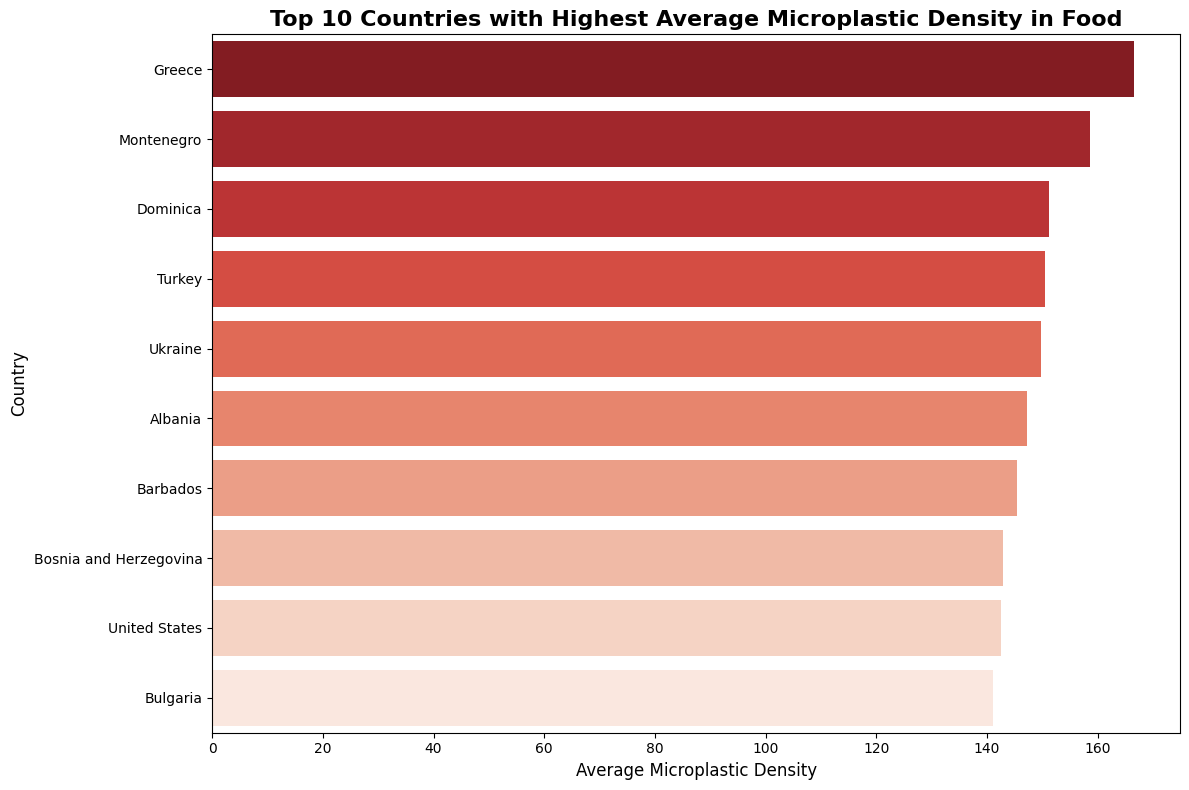

Plot 1 saved: data/plots/q1_top_countries_microplastics.png
Top 10 countries:
 1. Greece: 166.56
 2. Montenegro: 158.57
 3. Dominica: 151.18
 4. Turkey: 150.58
 5. Ukraine: 149.73
 6. Albania: 147.27
 7. Barbados: 145.49
 8. Bosnia and Herzegovina: 142.88
 9. United States: 142.56
10. Bulgaria: 141.01

QUESTION 2: Microplastic Density Trends Over Years


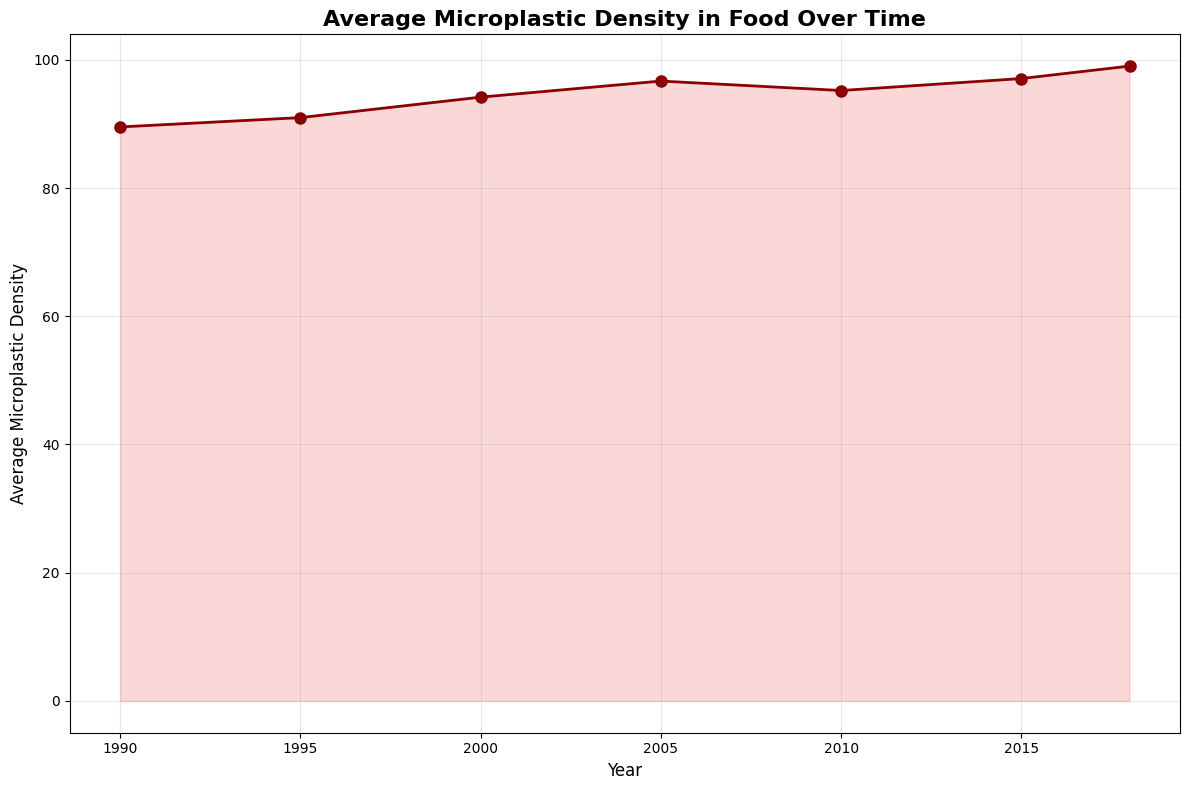

Plot 2 saved: data/plots/q2_microplastics_time_series.png
Time trend shows microplastic density from 1990 to 2018


In [ ]:
print("Top 10 Countries with Highest Microplastic Density")

os.makedirs('data/plots', exist_ok=True)

# Convert to pandas for visualization
top_countries_pd = top_countries_gold.limit(10).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=top_countries_pd, x='avg_microplastic_density', y='country', palette='Reds_r')
plt.title('Top 10 Countries with Highest Average Microplastic Density in Food', fontsize=16, fontweight='bold')
plt.xlabel('Average Microplastic Density', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('data/plots/q1_top_countries_microplastics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 1 saved: data/plots/q1_top_countries_microplastics.png")
print(f"Top 10 countries:")
for i, row in top_countries_pd.iterrows():
    print(f"{i+1:2d}. {row['country']}: {row['avg_microplastic_density']:.2f}")

# VISUALIZATION 2: Microplastic Density Over Time
print(f"\nQUESTION 2: Microplastic Density Trends Over Years")

time_series_pd = time_series_gold.toPandas()

plt.figure(figsize=(12, 8))
plt.plot(time_series_pd['year'], time_series_pd['avg_microplastic_density'], 
         marker='o', linewidth=2, markersize=8, color='darkred')
plt.fill_between(time_series_pd['year'], time_series_pd['avg_microplastic_density'], 
                 alpha=0.3, color='lightcoral')
plt.title('Average Microplastic Density in Food Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Microplastic Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/plots/q2_microplastics_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 2 saved: data/plots/q2_microplastics_time_series.png")
print(f"Time trend shows microplastic density from {time_series_pd['year'].min()} to {time_series_pd['year'].max()}")

QUESTION 1: Top 10 Countries with Highest Microplastic Density


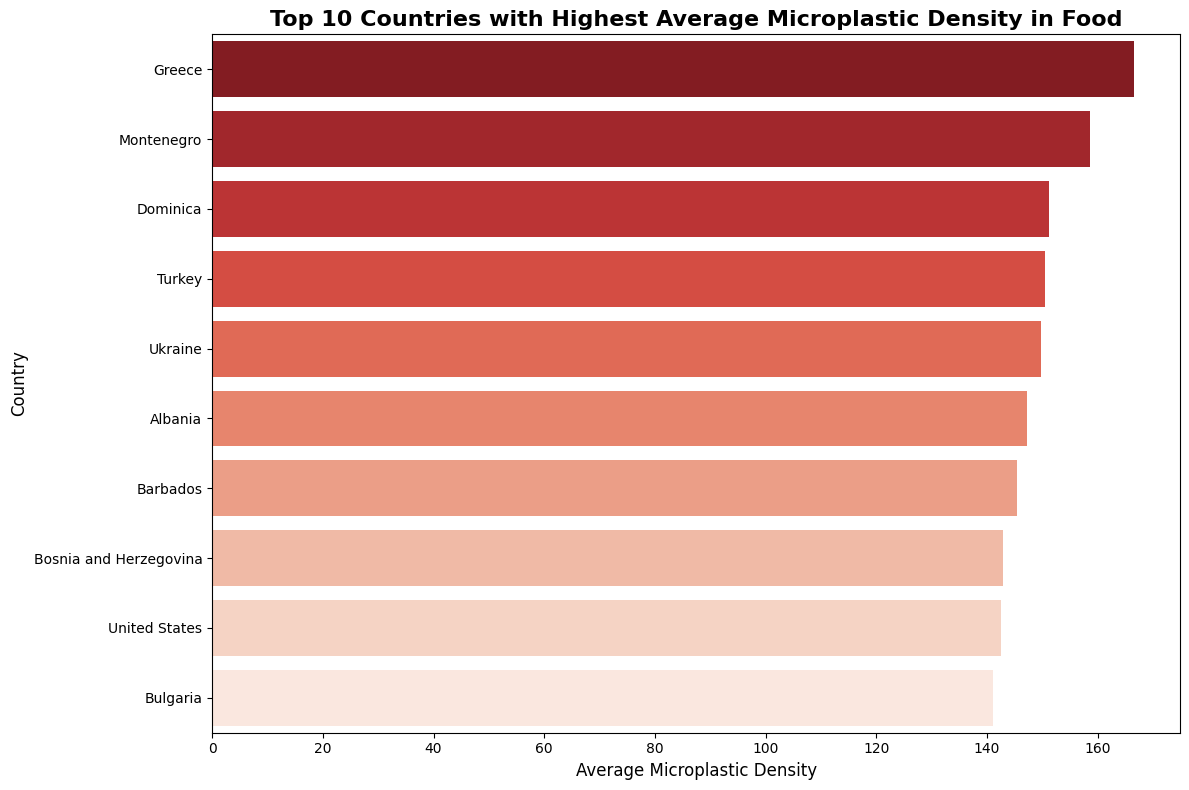

Plot 1 saved: data/plots/q1_top_countries_microplastics.png
Top 10 countries:
 1. Greece: 166.56
 2. Montenegro: 158.57
 3. Dominica: 151.18
 4. Turkey: 150.58
 5. Ukraine: 149.73
 6. Albania: 147.27
 7. Barbados: 145.49
 8. Bosnia and Herzegovina: 142.88
 9. United States: 142.56
10. Bulgaria: 141.01


In [ ]:
print("Top 10 Countries with Highest Microplastic Density")

# Convert to pandas for visualization
top_countries_pd = top_countries_gold.limit(10).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=top_countries_pd, x='avg_microplastic_density', y='country', hue='country', palette='Reds_r', legend=False)
plt.title('Top 10 Countries with Highest Average Microplastic Density in Food', fontsize=16, fontweight='bold')
plt.xlabel('Average Microplastic Density', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('data/plots/q1_top_countries_microplastics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 1 saved: data/plots/q1_top_countries_microplastics.png")
print(f"Top 10 countries:")
for i, row in top_countries_pd.iterrows():
    print(f"{i+1:2d}. {row['country']}: {row['avg_microplastic_density']:.2f}")


Microplastic Density Trends Over Years


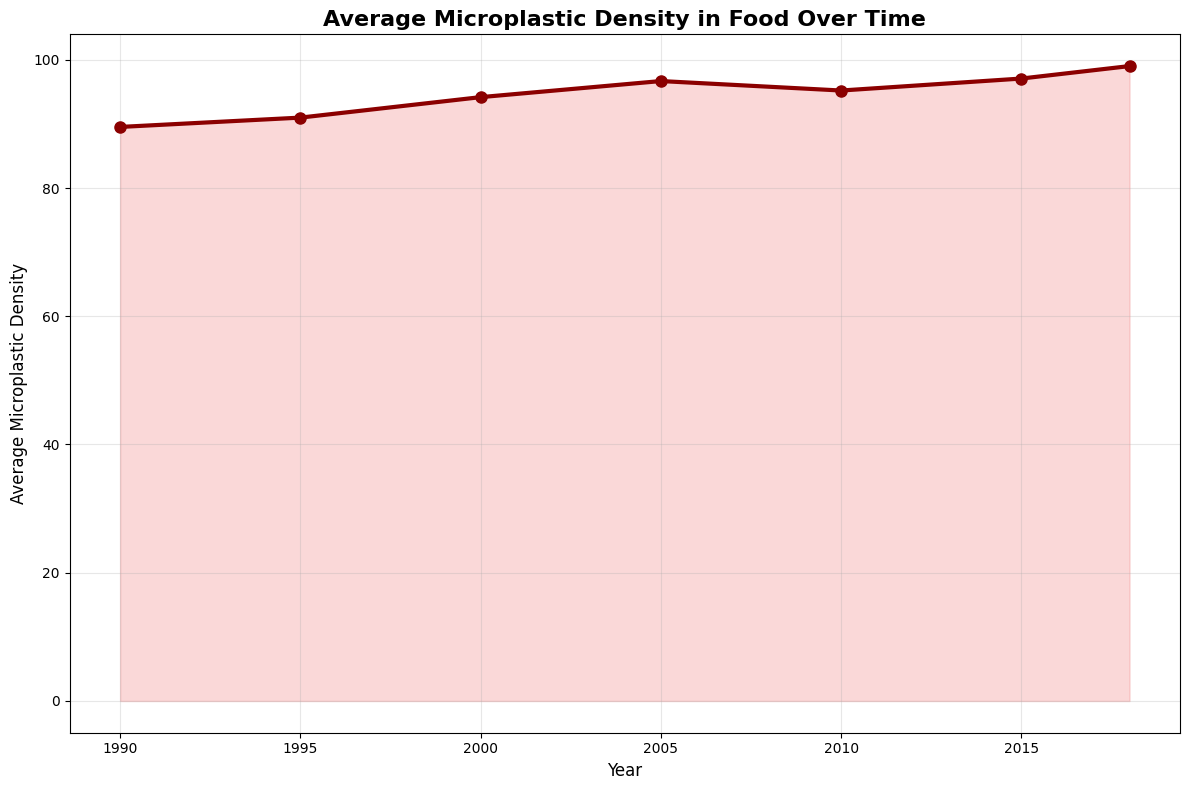

Plot 2 saved: data/plots/q2_microplastics_time_series.png
Time trend shows microplastic density from 1990 to 2018


In [ ]:
print(f"\nMicroplastic Density Trends Over Years")

time_series_pd = time_series_gold.toPandas()

plt.figure(figsize=(12, 8))
plt.plot(time_series_pd['year'], time_series_pd['avg_microplastic_density'], 
         marker='o', linewidth=3, markersize=8, color='darkred')
plt.fill_between(time_series_pd['year'], time_series_pd['avg_microplastic_density'], 
                 alpha=0.3, color='lightcoral')
plt.title('Average Microplastic Density in Food Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Microplastic Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/plots/q2_microplastics_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 2 saved: data/plots/q2_microplastics_time_series.png")
print(f"Time trend shows microplastic density from {time_series_pd['year'].min()} to {time_series_pd['year'].max()}")

Country-Specific Microplastic Trends (Greece as example)


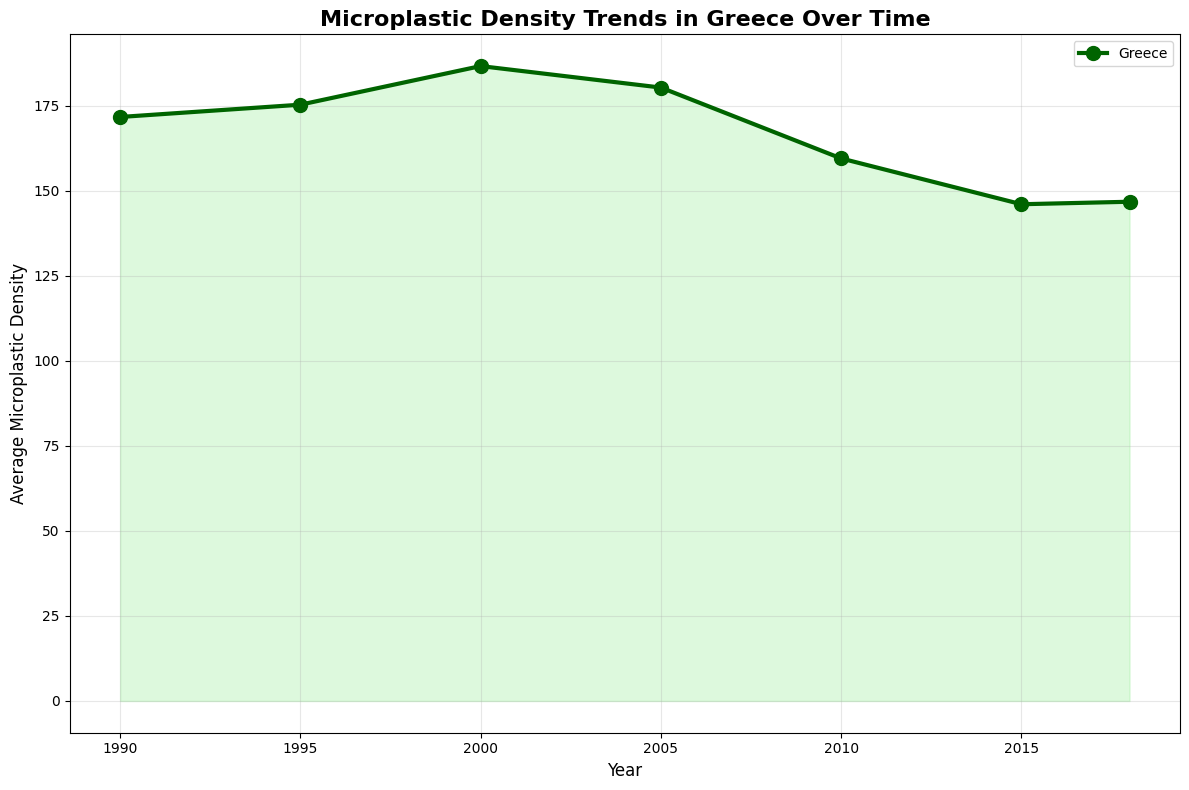

Plot 3 saved: data/plots/q3_greece_country_trends.png


In [455]:
print("Country-Specific Microplastic Trends (Greece as example)")

# Create country-specific analysis for Greece (highest contamination)
greece_trends = food_silver.filter(col("country") == "Greece").groupBy("year").agg(
    avg("microplastic_density").alias("avg_microplastic_density"),
    count("*").alias("sample_count")
).orderBy("year")

greece_trends_pd = greece_trends.toPandas()

plt.figure(figsize=(12, 8))
plt.plot(greece_trends_pd['year'], greece_trends_pd['avg_microplastic_density'], 
         marker='o', linewidth=3, markersize=10, color='darkgreen', label='Greece')
plt.fill_between(greece_trends_pd['year'], greece_trends_pd['avg_microplastic_density'], 
                 alpha=0.3, color='lightgreen')
plt.title('Microplastic Density Trends in Greece Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Microplastic Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('data/plots/q3_greece_country_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 3 saved: data/plots/q3_greece_country_trends.png")


Marine vs Sea Food Microplastic Contamination Correlation (Before 2014)


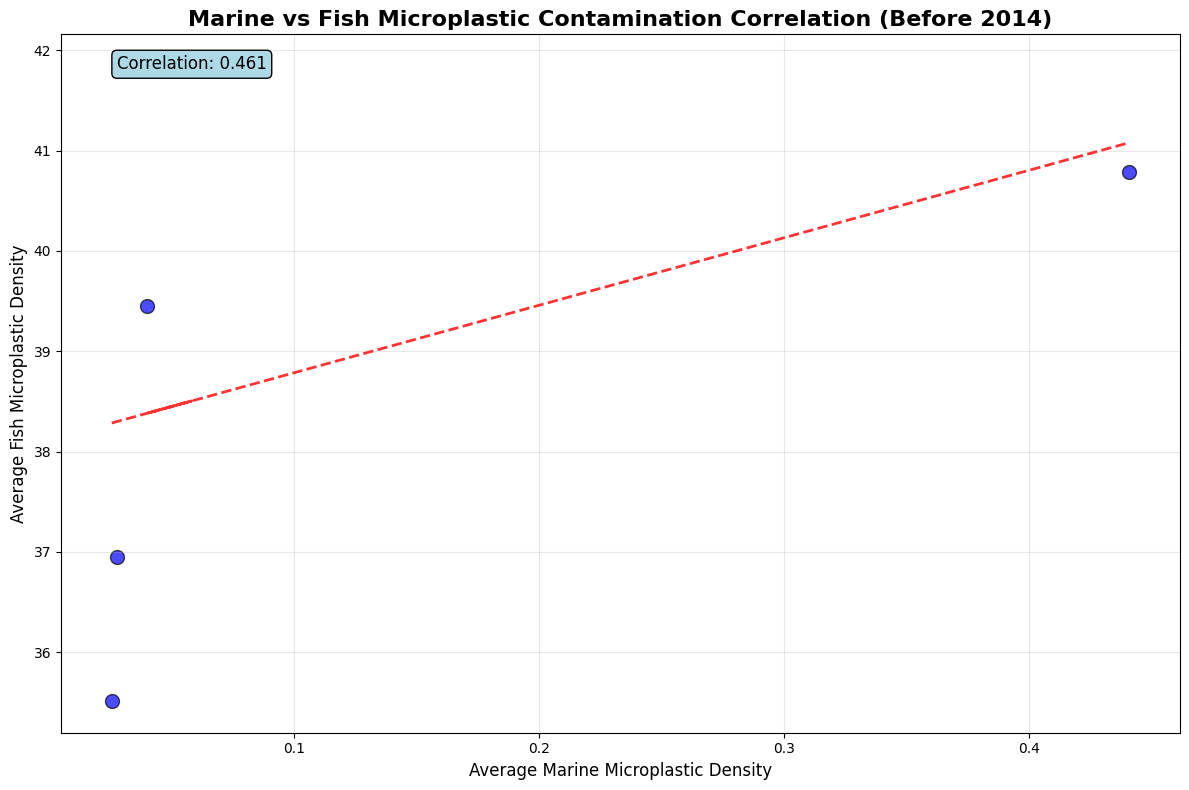

In [456]:
print(f"\nMarine vs Sea Food Microplastic Contamination Correlation (Before 2014)")

# Get fish data from food silver (years before 2014, because marine data is corrupted after 2014)
fish_data = food_silver.filter(
    (col("food_type") == "Fish") & (col("year") < 2014)
).groupBy("year").agg(
    avg("microplastic_density").alias("avg_fish_contamination")
).orderBy("year")

# Get marine data by year (years before 2014)
marine_yearly = marine_silver.filter(col("year") < 2014).select(
    "year", "avg_microplastic_density"
).orderBy("year")

# Join the datasets
fish_marine_data = fish_data.join(marine_yearly, "year", "inner").toPandas()

plt.figure(figsize=(12, 8))

# Create scatter plot for correlation
plt.scatter(fish_marine_data['avg_microplastic_density'], 
           fish_marine_data['avg_fish_contamination'],
           s=100, alpha=0.7, color='blue', edgecolors='black')

# Add trend line
if len(fish_marine_data) > 1:
    z = np.polyfit(fish_marine_data['avg_microplastic_density'], 
                   fish_marine_data['avg_fish_contamination'], 1)
    p = np.poly1d(z)
    plt.plot(fish_marine_data['avg_microplastic_density'], 
             p(fish_marine_data['avg_microplastic_density']), 
             "r--", alpha=0.8, linewidth=2)
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(fish_marine_data['avg_microplastic_density'], 
                             fish_marine_data['avg_fish_contamination'])[0,1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

plt.title('Marine vs Fish Microplastic Contamination Correlation (Before 2014)', fontsize=16, fontweight='bold')
plt.xlabel('Average Marine Microplastic Density', fontsize=12)
plt.ylabel('Average Fish Microplastic Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/plots/q4_marine_fish_correlation.png', dpi=300, bbox_inches='tight')
plt.show()



Development Level vs Microplastic Contamination


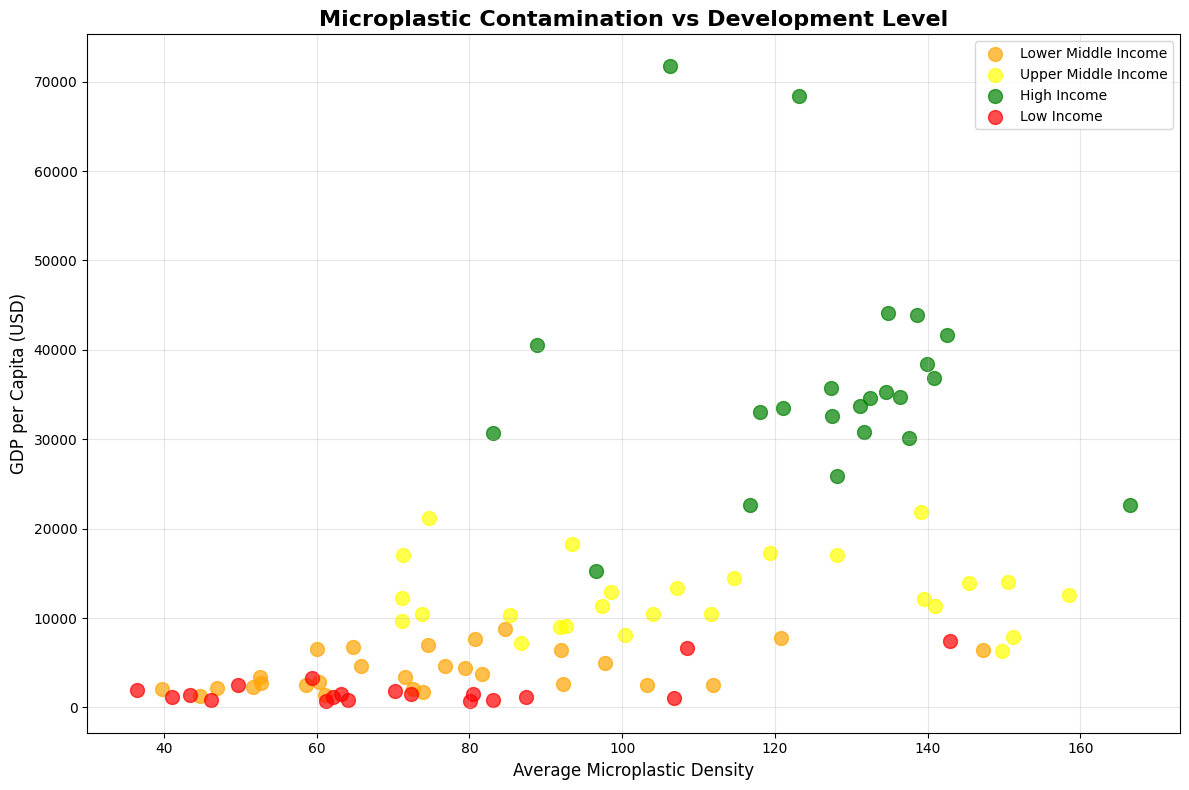

Plot 5 saved: data/plots/q5_development_contamination.png


In [457]:
print(f"\nDevelopment Level vs Microplastic Contamination")

# Join food and GDP data
development_microplastics = food_silver.groupBy("country").agg(
    avg("microplastic_density").alias("avg_contamination")
).join(
    gdp_silver.groupBy("country").agg(
        avg("gdp_per_capita").alias("avg_gdp"),
        first("development_level").alias("development_level")
    ), "country", "inner"
).join(health_silver.select("country", "region"), "country", "left")

dev_micro_pd = development_microplastics.toPandas()

plt.figure(figsize=(12, 8))
colors = {'Low Income': 'red', 'Lower Middle Income': 'orange', 
          'Upper Middle Income': 'yellow', 'High Income': 'green'}

for dev_level in dev_micro_pd['development_level'].unique():
    data = dev_micro_pd[dev_micro_pd['development_level'] == dev_level]
    plt.scatter(data['avg_contamination'], data['avg_gdp'], 
               label=dev_level, alpha=0.7, s=100,
               color=colors.get(dev_level, 'gray'))

plt.title('Microplastic Contamination vs Development Level', fontsize=16, fontweight='bold')
plt.xlabel('Average Microplastic Density', fontsize=12)
plt.ylabel('GDP per Capita (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/plots/q5_development_contamination.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 5 saved: data/plots/q5_development_contamination.png")

Top 10 Foods with Highest Microplastic Density


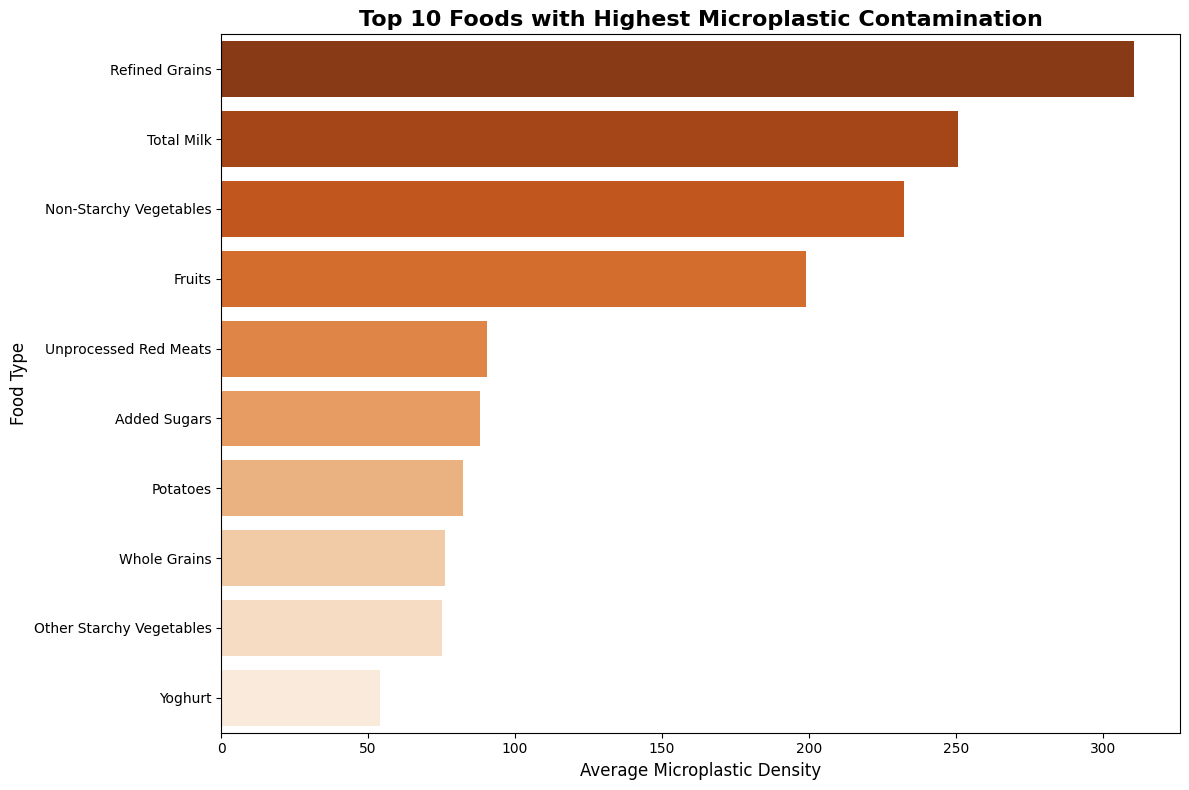

Plot 6 saved: data/plots/q6_top_foods_contamination.png
Top 10 most contaminated foods:
 1. Refined Grains: 310.73
 2. Total Milk: 250.66
 3. Non-Starchy Vegetables: 232.41
 4. Fruits: 198.89
 5. Unprocessed Red Meats: 90.33
 6. Added Sugars: 87.98
 7. Potatoes: 82.46
 8. Whole Grains: 76.09
 9. Other Starchy Vegetables: 75.23
10. Yoghurt: 54.18

Fertility Rate vs Microplastic Contamination


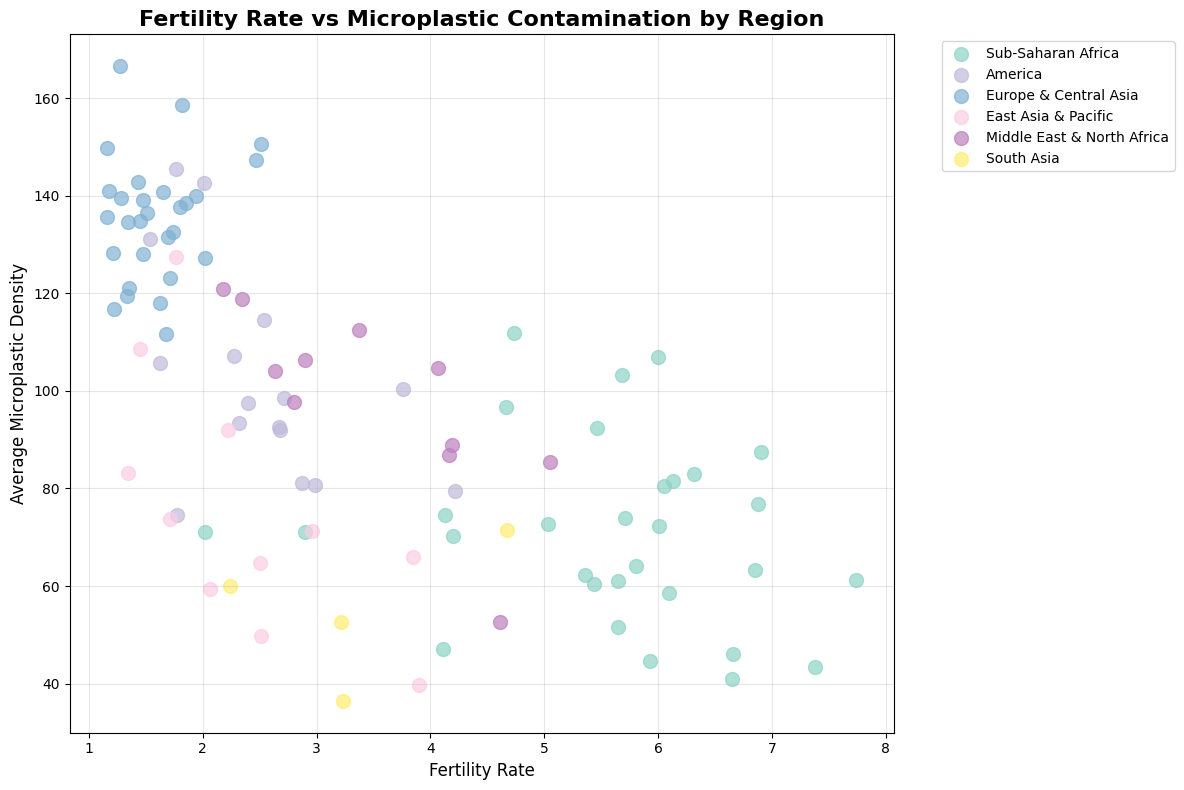

Plot 7 saved: data/plots/q7_fertility_contamination.png


In [458]:
print("Top 10 Foods with Highest Microplastic Density")

top_foods_pd = top_foods_gold.limit(10).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=top_foods_pd, x='avg_microplastic_density', y='food_type', 
            hue='food_type', palette='Oranges_r', legend=False)
plt.title('Top 10 Foods with Highest Microplastic Contamination', fontsize=16, fontweight='bold')
plt.xlabel('Average Microplastic Density', fontsize=12)
plt.ylabel('Food Type', fontsize=12)
plt.tight_layout()
plt.savefig('data/plots/q6_top_foods_contamination.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 6 saved: data/plots/q6_top_foods_contamination.png")
print(f"Top 10 most contaminated foods:")
for i, row in top_foods_pd.iterrows():
    print(f"{i+1:2d}. {row['food_type']}: {row['avg_microplastic_density']:.2f}")
    

print(f"\nFertility Rate vs Microplastic Contamination")

# Join health and food data
fertility_microplastics = health_silver.select("country", "fertility_rate", "region").join(
    food_silver.groupBy("country").agg(avg("microplastic_density").alias("avg_contamination")),
    "country", "inner"
)

fertility_micro_pd = fertility_microplastics.toPandas()

plt.figure(figsize=(12, 8))
regions = fertility_micro_pd['region'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(regions)))

for region, color in zip(regions, colors):
    if pd.notna(region):
        data = fertility_micro_pd[fertility_micro_pd['region'] == region]
        plt.scatter(data['fertility_rate'], data['avg_contamination'], 
                   label=region, alpha=0.7, s=100, color=color)

plt.title('Fertility Rate vs Microplastic Contamination by Region', fontsize=16, fontweight='bold')
plt.xlabel('Fertility Rate', fontsize=12)
plt.ylabel('Average Microplastic Density', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/plots/q7_fertility_contamination.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 7 saved: data/plots/q7_fertility_contamination.png")


Life Expectancy vs Microplastic Contamination


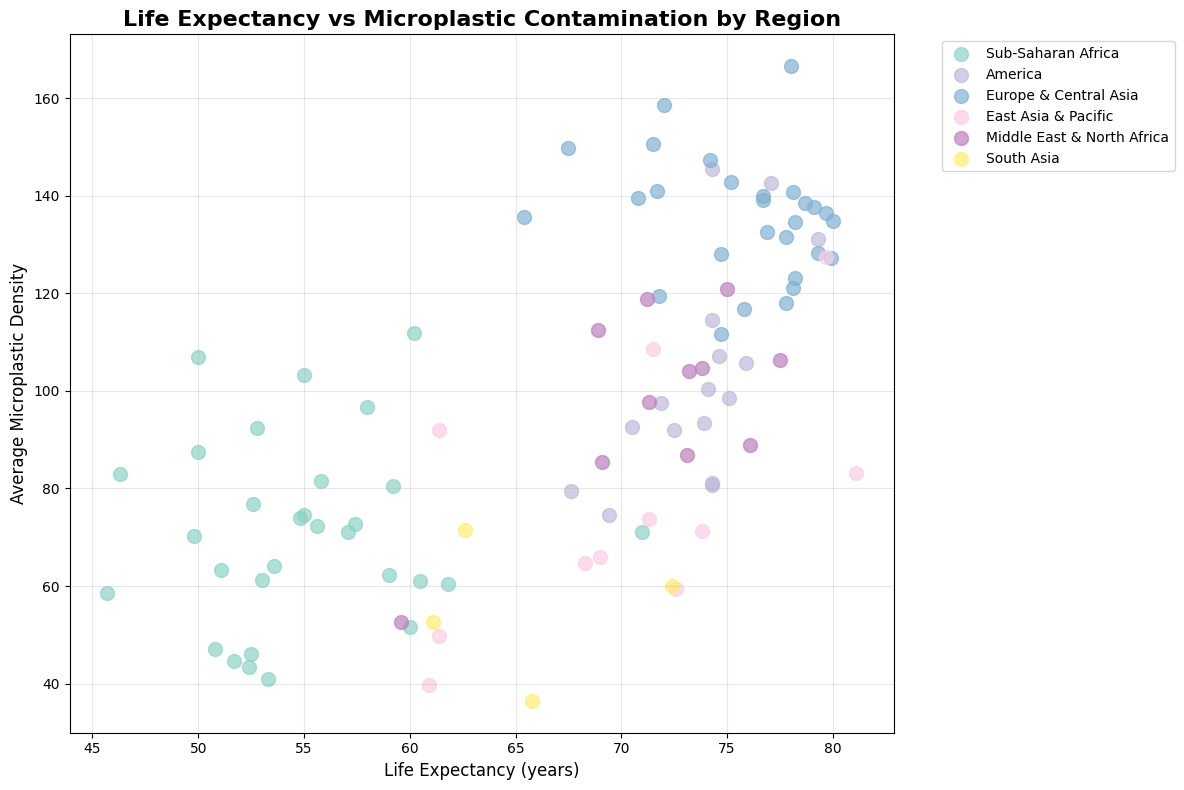

Plot 8 saved: data/plots/q8_life_expectancy_contamination.png

 ALL VISUALIZATIONS COMPLETED!
All plots saved in: data/plots/
Gold layer tables saved in: data/gold/
8 analysis questions fully answered with visualizations!


In [459]:
print(f"\nLife Expectancy vs Microplastic Contamination")

# Join health and food data
life_exp_microplastics = health_silver.select("country", "life_expectancy", "region").join(
    food_silver.groupBy("country").agg(avg("microplastic_density").alias("avg_contamination")),
    "country", "inner"
)

life_exp_micro_pd = life_exp_microplastics.toPandas()

plt.figure(figsize=(12, 8))
for region, color in zip(regions, colors):
    if pd.notna(region):
        data = life_exp_micro_pd[life_exp_micro_pd['region'] == region]
        plt.scatter(data['life_expectancy'], data['avg_contamination'], 
                   label=region, alpha=0.7, s=100, color=color)

plt.title('Life Expectancy vs Microplastic Contamination by Region', fontsize=16, fontweight='bold')
plt.xlabel('Life Expectancy (years)', fontsize=12)
plt.ylabel('Average Microplastic Density', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/plots/q8_life_expectancy_contamination.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot 8 saved: data/plots/q8_life_expectancy_contamination.png")

spark.stop()

print(f"\n ALL VISUALIZATIONS COMPLETED!")
print("="*50)
print(f"All plots saved in: data/plots/")
print(f"Gold layer tables saved in: data/gold/")
print(f"8 analysis questions fully answered with visualizations!")